In [1]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, glob, collections, time, itertools

import ujson as json

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask
import dask.distributed 
import dask.dataframe as dd

import large_image

import histomicstk as htk
import histomicstk.preprocessing.color_normalization as htk_cnorm
import histomicstk.preprocessing.color_deconvolution as htk_cdeconv
import histomicstk.features as htk_features
import histomicstk.utils as htk_utils
import histomicstk.segmentation.nuclear as htk_nuclear
import histomicstk.segmentation.label as htk_seg_label
import histomicstk.filters.shape as htk_shape_filters

import logging
logging.basicConfig(level=logging.CRITICAL)

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['axes.grid'] = True
plt.gray()

INFO:root:Created LRU Cache for 'tilesource' with 671 maximum size
INFO:root:Notice: Could not import MapnikTileSource


<Figure size 1080x1080 with 0 Axes>

### Connect to dask cluster

In [42]:
c = dask.distributed.Client('localhost:8786')
display(c)

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 14 Cores: 14 Memory: 118.23 GB


### Load training feature files

In [43]:
FEATURE_ROOT_DIR = '/home/deepak.chittajallu/emory/code/IHC-Analysis/BagOfWords/results'

In [45]:
df = dd.read_hdf(os.path.join(FEATURE_ROOT_DIR, '*.hdf'), key='features')

### Train k-means model

In [66]:
from sklearn.pipeline import Pipeline  # regular scikit-learn pipeline
from dask_ml.cluster import KMeans
from dask_ml.preprocessing import RobustScaler
from dask_ml.impute import SimpleImputer

km_model = Pipeline([
    ('impute', SimpleImputer()),
    ('normalize', RobustScaler()),
    ('cluster', KMeans(n_clusters=100, random_state=0))
])

km_model.fit(df)

INFO:root:Starting _check_array
INFO:root:Finished _check_array in 0:00:11.350156
INFO:root:Starting init_scalable
INFO:dask_ml.cluster.k_means:Initializing with k-means||
INFO:dask_ml.cluster.k_means:Starting init iteration  1/20 ,  1 centers
INFO:dask_ml.cluster.k_means:Finished init iteration  1/20 ,  1 centers in 0:00:06.519895
INFO:dask_ml.cluster.k_means:Starting init iteration  2/20 ,  5 centers
INFO:dask_ml.cluster.k_means:Finished init iteration  2/20 ,  5 centers in 0:00:07.767975
INFO:dask_ml.cluster.k_means:Starting init iteration  3/20 ,  5 centers
INFO:dask_ml.cluster.k_means:Finished init iteration  3/20 ,  5 centers in 0:00:06.920380
INFO:dask_ml.cluster.k_means:Starting init iteration  4/20 ,  7 centers
INFO:dask_ml.cluster.k_means:Finished init iteration  4/20 ,  7 centers in 0:00:07.318256
INFO:dask_ml.cluster.k_means:Starting init iteration  5/20 , 11 centers
INFO:dask_ml.cluster.k_means:Finished init iteration  5/20 , 11 centers in 0:00:07.018719
INFO:dask_ml.clust

INFO:dask_ml.cluster.k_means:Starting Lloyd loop 28.
INFO:dask_ml.cluster.k_means:Shift: 32.5744
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 28. in 0:00:10.954155
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 29.
INFO:dask_ml.cluster.k_means:Shift: 85.9591
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 29. in 0:00:10.856783
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 30.
INFO:dask_ml.cluster.k_means:Shift: 21.0096
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 30. in 0:00:10.654558
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 31.
INFO:dask_ml.cluster.k_means:Shift: 24.3993
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 31. in 0:00:10.040501
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 32.
INFO:dask_ml.cluster.k_means:Shift: 18.4970
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 32. in 0:00:10.954814
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 33.
INFO:dask_ml.cluster.k_means:Shift: 12.3755
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 33. in 0:00:10

INFO:dask_ml.cluster.k_means:Starting Lloyd loop 77.
INFO:dask_ml.cluster.k_means:Shift: 3.9908
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 77. in 0:00:11.009749
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 78.
INFO:dask_ml.cluster.k_means:Shift: 3.0558
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 78. in 0:00:11.567234
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 79.
INFO:dask_ml.cluster.k_means:Shift: 2.0874
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 79. in 0:00:12.358173
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 80.
INFO:dask_ml.cluster.k_means:Shift: 1.8386
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 80. in 0:00:10.463223
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 81.
INFO:dask_ml.cluster.k_means:Shift: 2.7260
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 81. in 0:00:10.551406
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 82.
INFO:dask_ml.cluster.k_means:Shift: 4.6317
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 82. in 0:00:11.21342

INFO:dask_ml.cluster.k_means:Starting Lloyd loop 126.
INFO:dask_ml.cluster.k_means:Shift: 0.4503
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 126. in 0:00:10.856196
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 127.
INFO:dask_ml.cluster.k_means:Shift: 0.5011
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 127. in 0:00:11.467442
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 128.
INFO:dask_ml.cluster.k_means:Shift: 1.1001
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 128. in 0:00:10.254974
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 129.
INFO:dask_ml.cluster.k_means:Shift: 0.8255
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 129. in 0:00:11.415302
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 130.
INFO:dask_ml.cluster.k_means:Shift: 0.8453
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 130. in 0:00:11.457092
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 131.
INFO:dask_ml.cluster.k_means:Shift: 1.2207
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 131. in 0

INFO:dask_ml.cluster.k_means:Finished Lloyd loop 174. in 0:00:11.707156
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 175.
INFO:dask_ml.cluster.k_means:Shift: 0.1043
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 175. in 0:00:10.719199
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 176.
INFO:dask_ml.cluster.k_means:Shift: 0.0944
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 176. in 0:00:10.359987
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 177.
INFO:dask_ml.cluster.k_means:Shift: 0.1020
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 177. in 0:00:10.567298
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 178.
INFO:dask_ml.cluster.k_means:Shift: 0.1591
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 178. in 0:00:10.706250
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 179.
INFO:dask_ml.cluster.k_means:Shift: 0.1440
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 179. in 0:00:10.301085
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 180.
INFO:dask_ml.cluster.k_means:

INFO:dask_ml.cluster.k_means:Shift: 0.2699
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 223. in 0:00:10.801570
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 224.
INFO:dask_ml.cluster.k_means:Shift: 0.1514
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 224. in 0:00:10.801392
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 225.
INFO:dask_ml.cluster.k_means:Shift: 0.1052
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 225. in 0:00:10.772933
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 226.
INFO:dask_ml.cluster.k_means:Shift: 0.1502
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 226. in 0:00:10.752178
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 227.
INFO:dask_ml.cluster.k_means:Shift: 0.1894
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 227. in 0:00:10.308215
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 228.
INFO:dask_ml.cluster.k_means:Shift: 0.1320
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 228. in 0:00:11.612518
INFO:dask_ml.cluster.k_means:Starting Ll

INFO:dask_ml.cluster.k_means:Starting Lloyd loop 272.
INFO:dask_ml.cluster.k_means:Shift: 2.1414
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 272. in 0:00:10.402572
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 273.
INFO:dask_ml.cluster.k_means:Shift: 4.4569
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 273. in 0:00:13.274855
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 274.
INFO:dask_ml.cluster.k_means:Shift: 3.9473
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 274. in 0:00:11.104023
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 275.
INFO:dask_ml.cluster.k_means:Shift: 1.6839
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 275. in 0:00:11.354726
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 276.
INFO:dask_ml.cluster.k_means:Shift: 2.4223
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 276. in 0:00:10.903621
INFO:dask_ml.cluster.k_means:Starting Lloyd loop 277.
INFO:dask_ml.cluster.k_means:Shift: 1.3416
INFO:dask_ml.cluster.k_means:Finished Lloyd loop 277. in 0

Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('normalize', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('cluster', KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=None,
    max_iter=300, n_clusters=100, n_jobs=1, oversampling_factor=2,
    precompute_distances='auto', random_state=0, tol=0.0001))])

In [67]:
from sklearn.externals import joblib
_ = joblib.dump(km_model, os.path.join(FEATURE_ROOT_DIR, 'kmeans_pipeline.joblib'))

### Visualize cluster examples

In [68]:
DATA_ROOT_DIR = '/media/nvme/Projects/emory/lymphoma/cmyc'

In [69]:
from sklearn.externals import joblib
km_model = joblib.load(os.path.join(FEATURE_ROOT_DIR, 'kmeans_pipeline.joblib'))

In [70]:
sample_file = '0118_CMYC_01.ndpi'

with open(os.path.join(FEATURE_ROOT_DIR, sample_file + '.anot')) as f:
    sample_anot = np.array(json.load(f)['elements'])
    
sample_df = dd.read_hdf(os.path.join(FEATURE_ROOT_DIR, sample_file + '.hdf'), key='features')

In [71]:
sample_clusters = np.array(km_model.predict(sample_df))

INFO:root:Starting _check_array
INFO:root:Finished _check_array in 0:00:12.137544


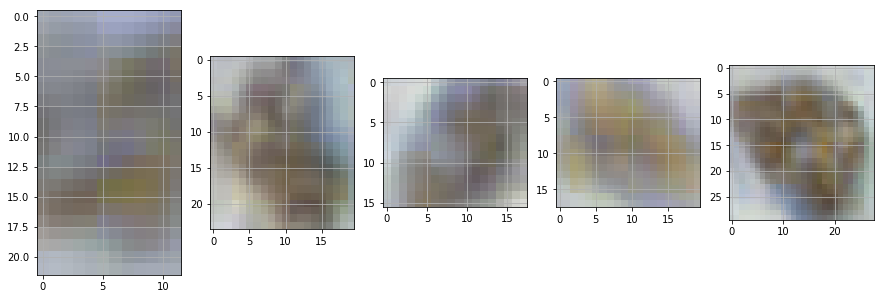

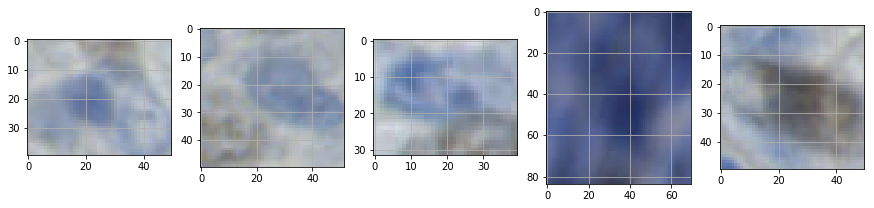

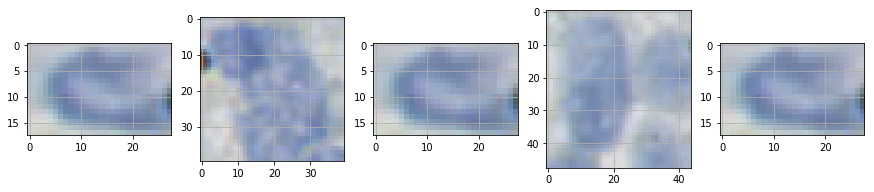

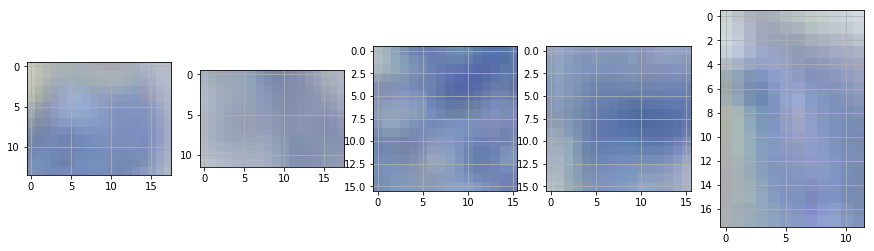

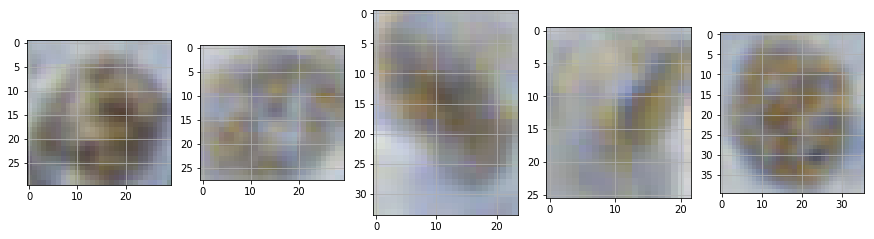

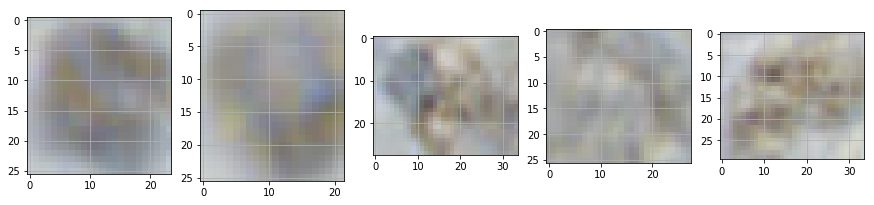

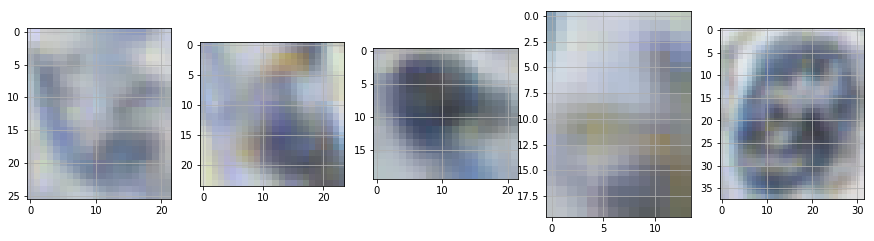

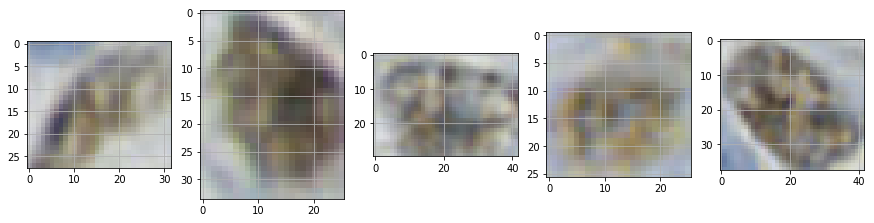

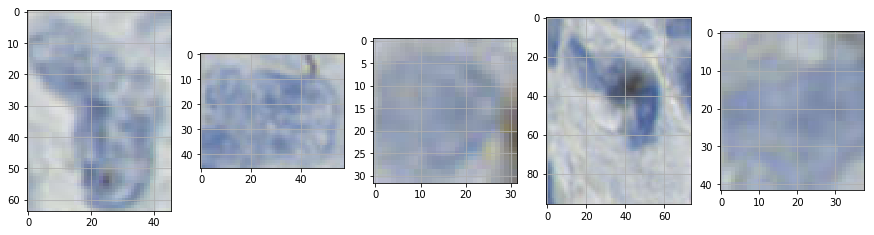

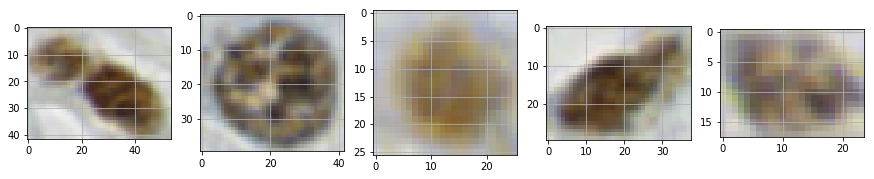

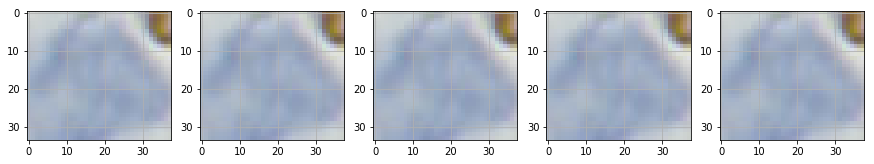

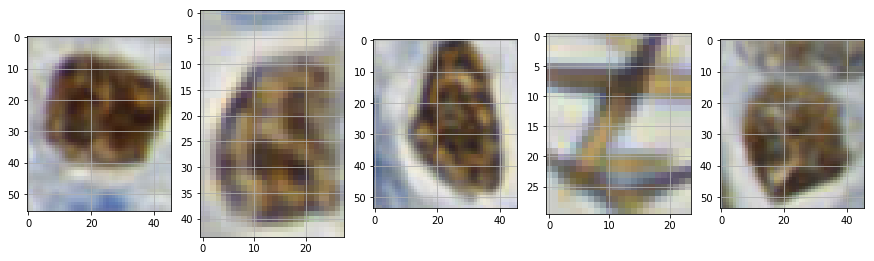

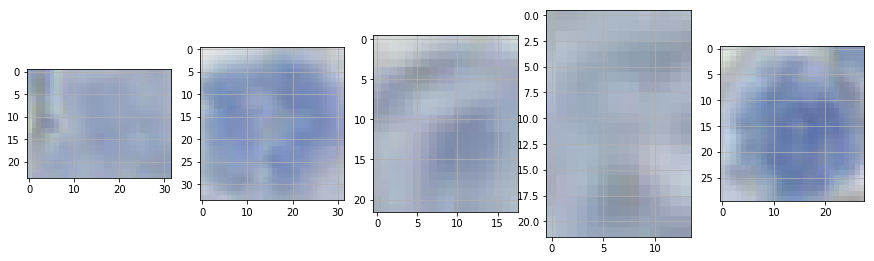

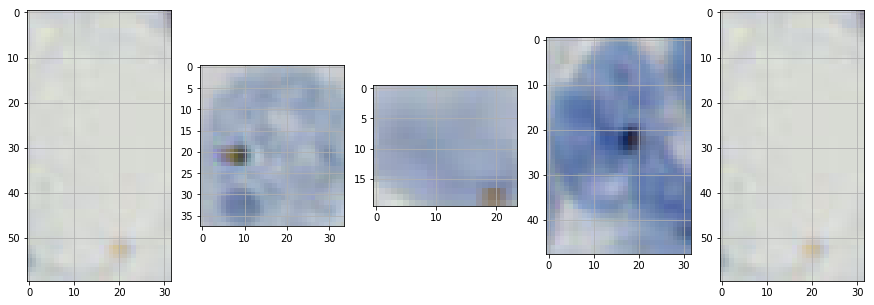

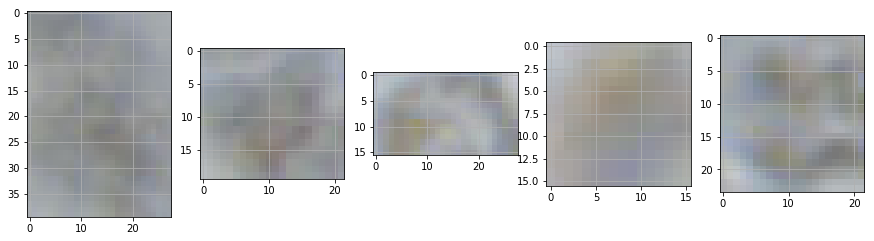

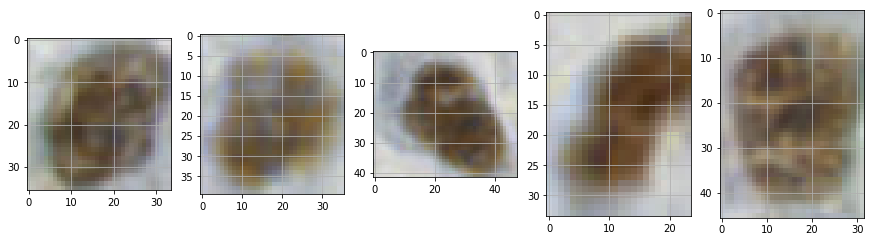

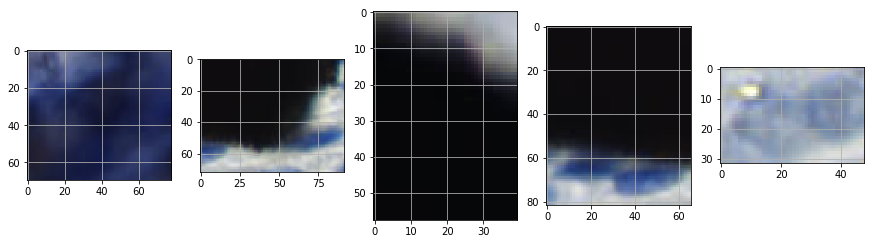

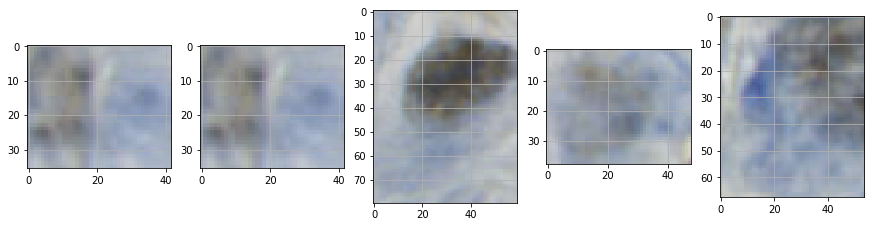

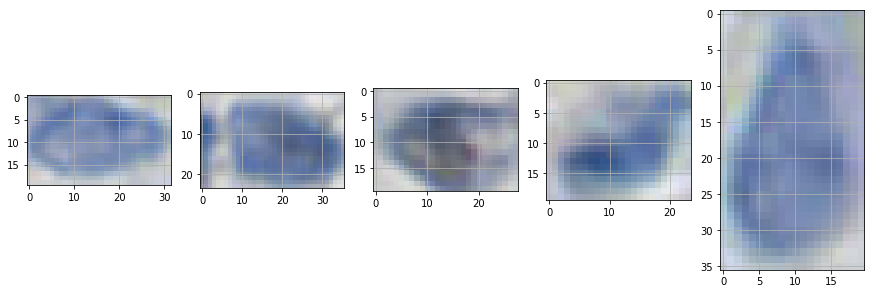

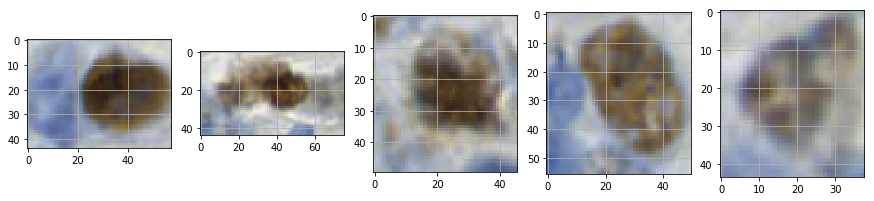

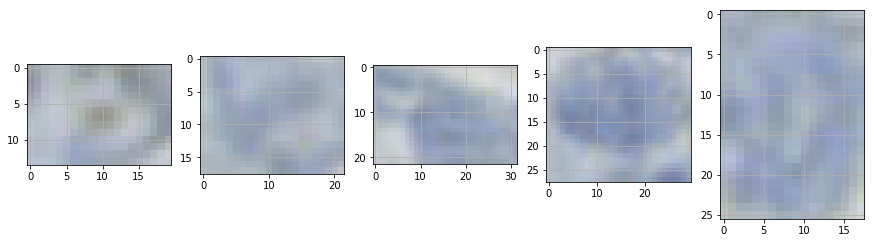

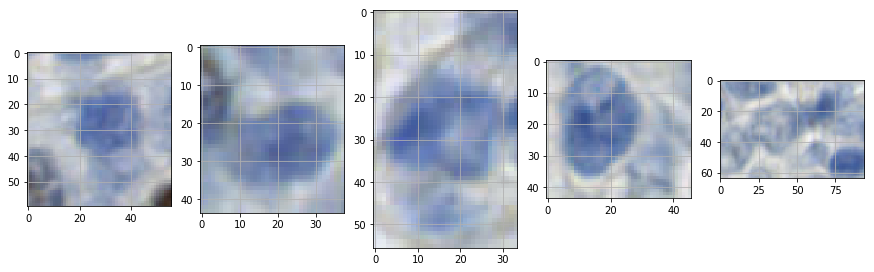

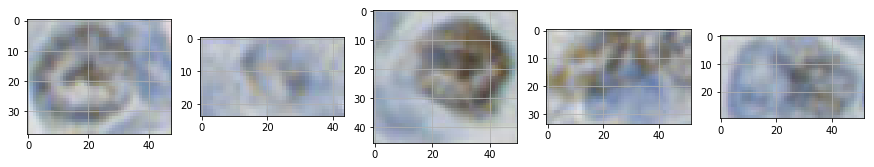

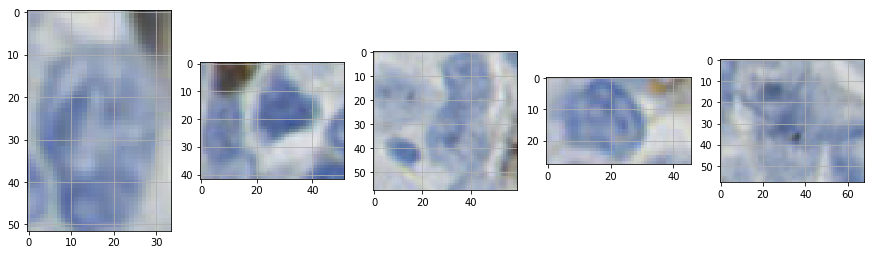

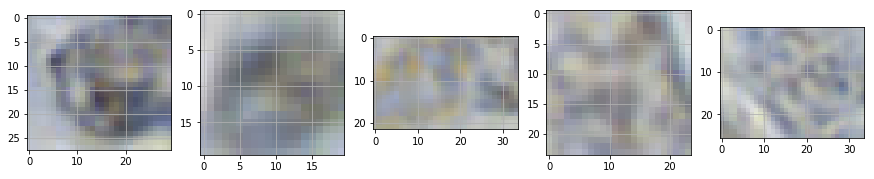

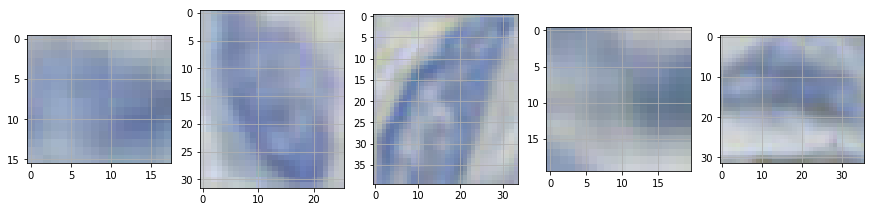

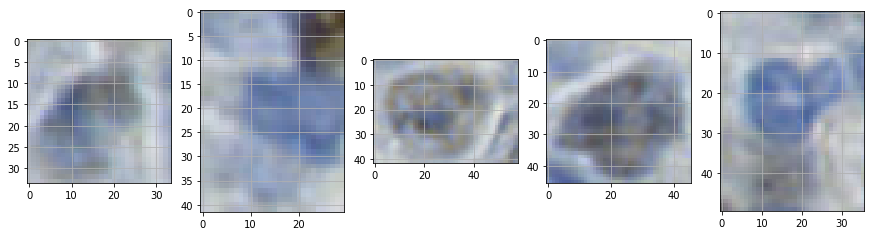

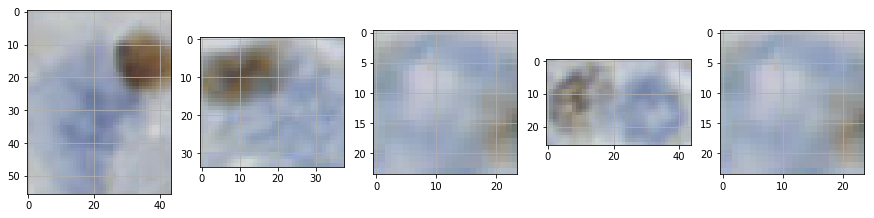

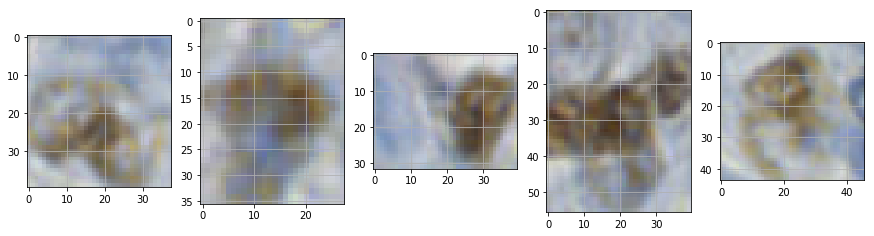

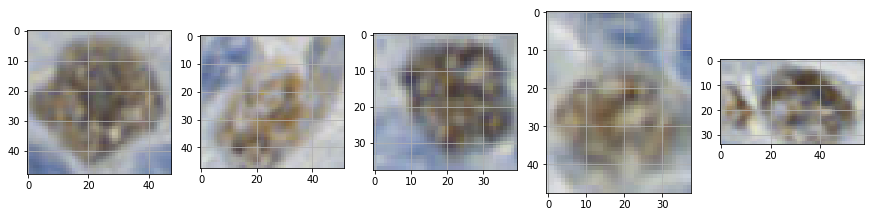

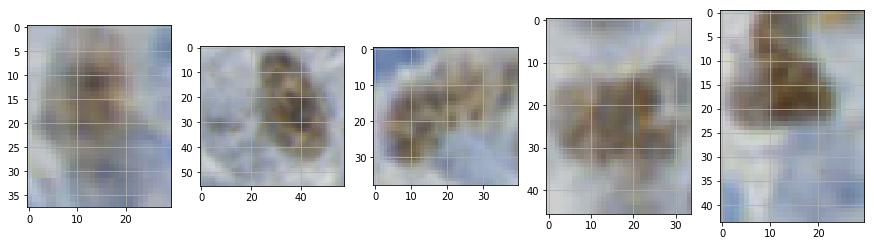

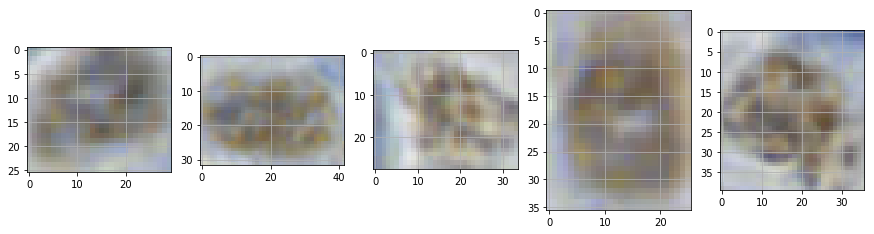

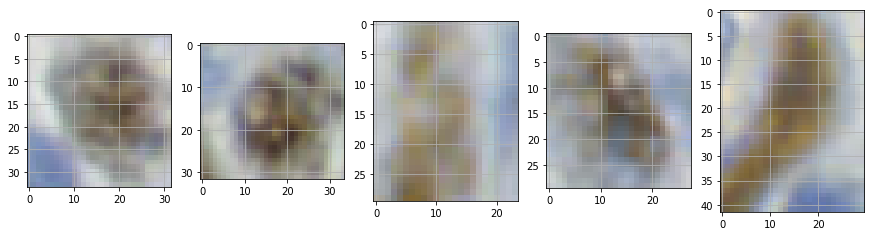

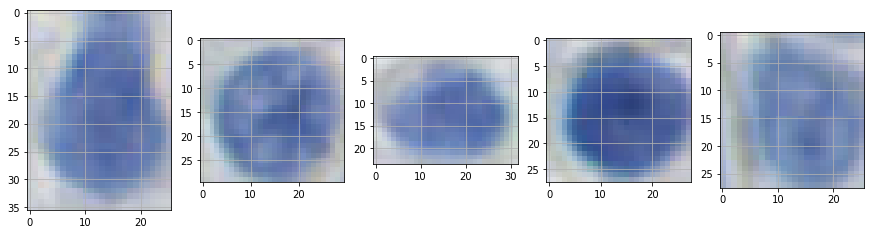

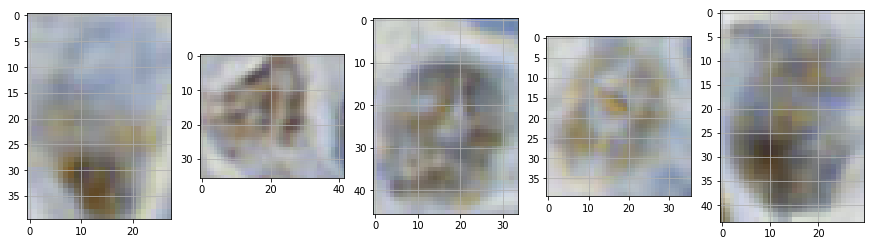

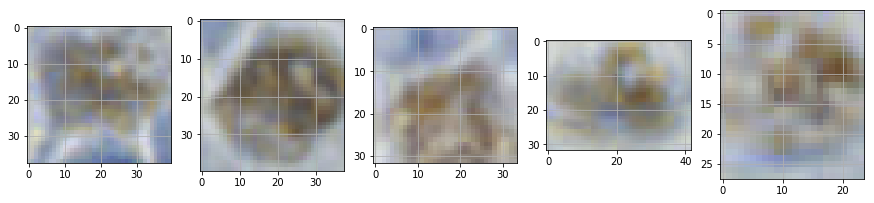

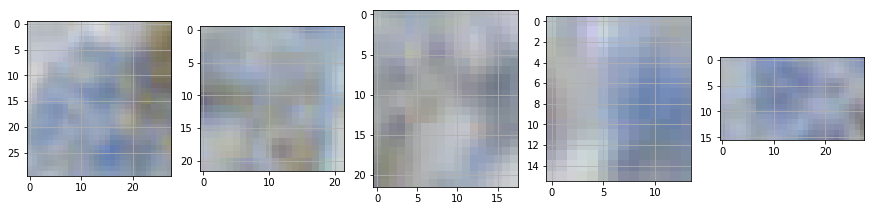

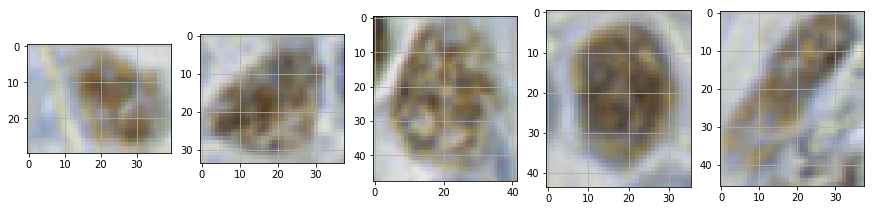

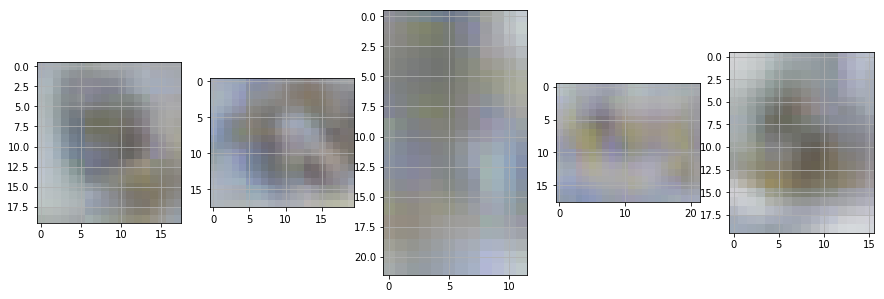

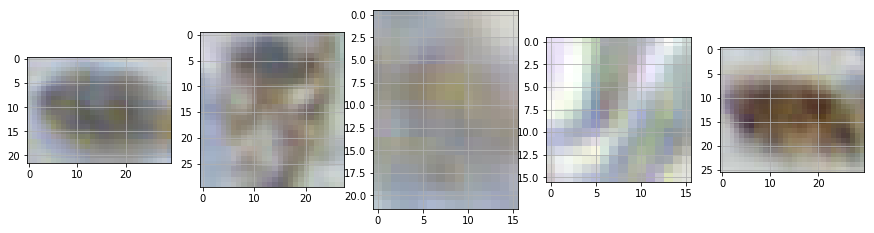

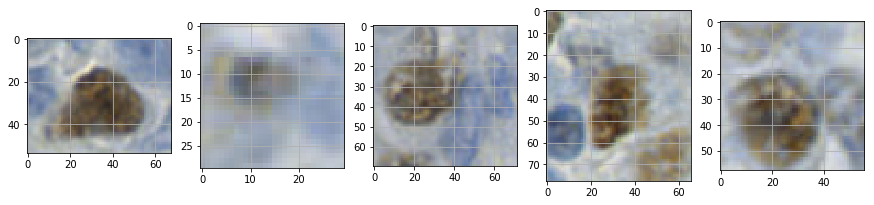

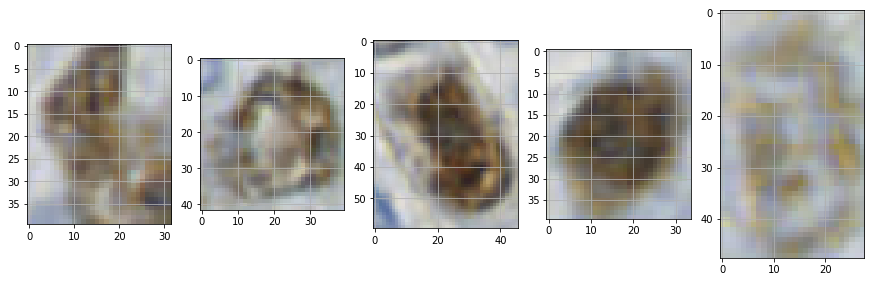

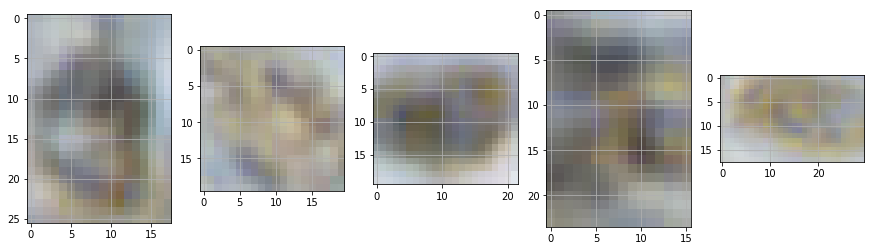

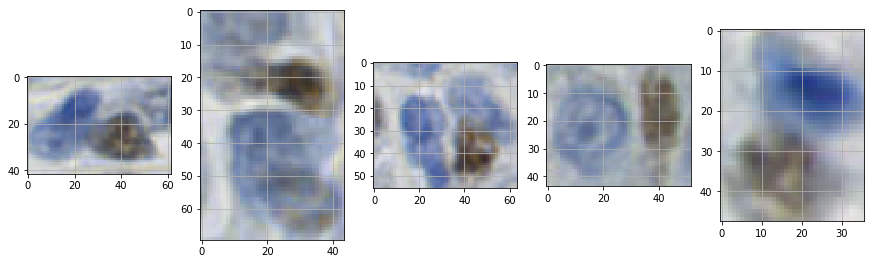

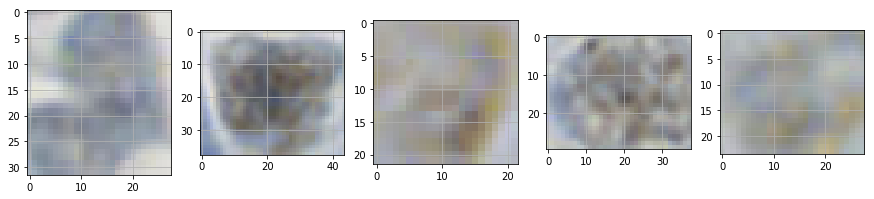

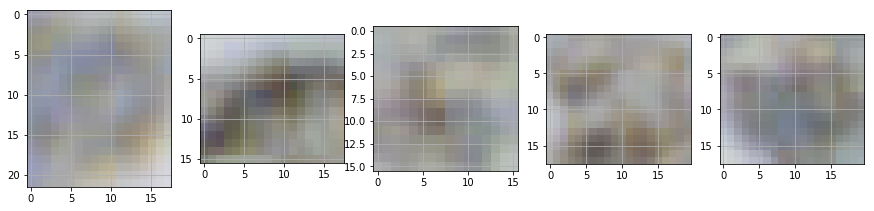

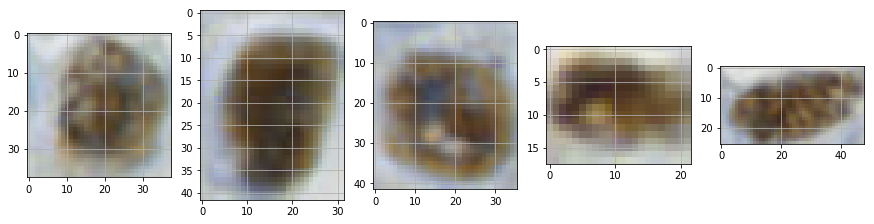

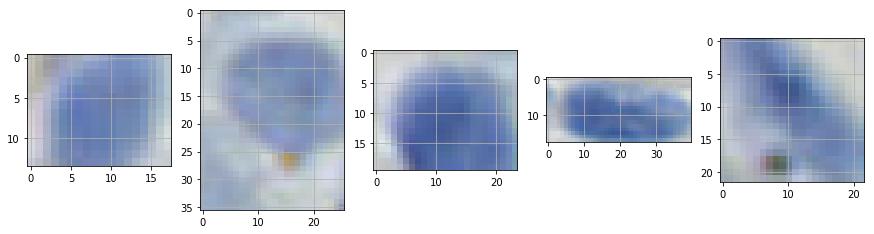

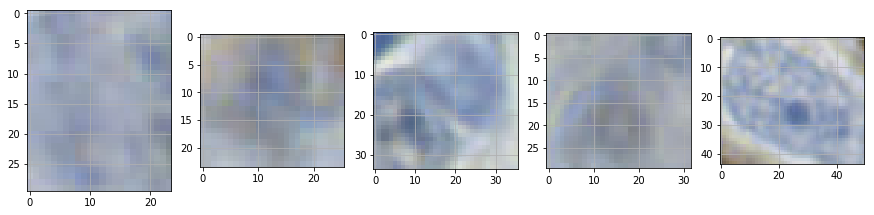

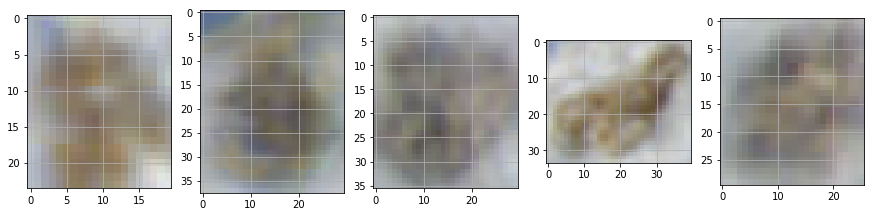

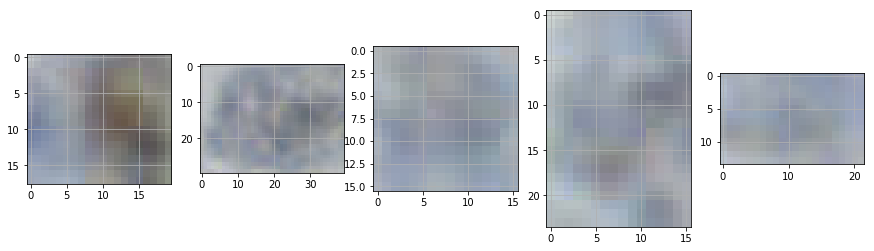

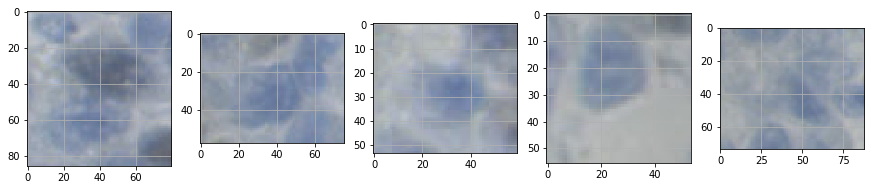

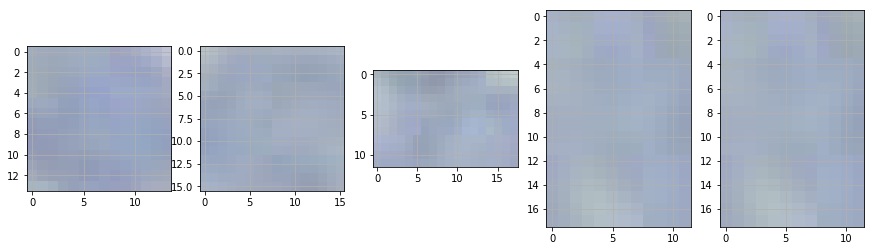

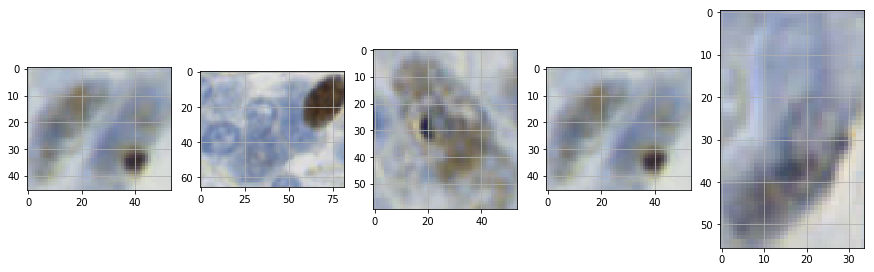

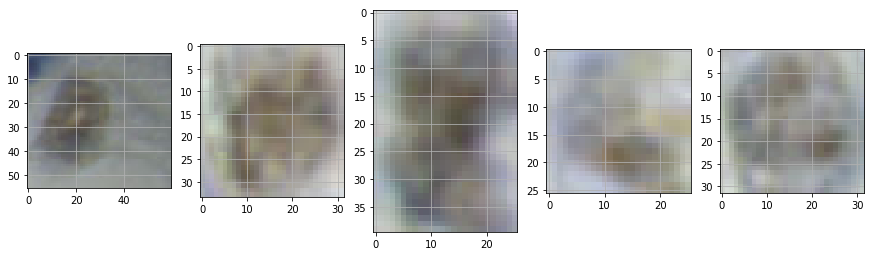

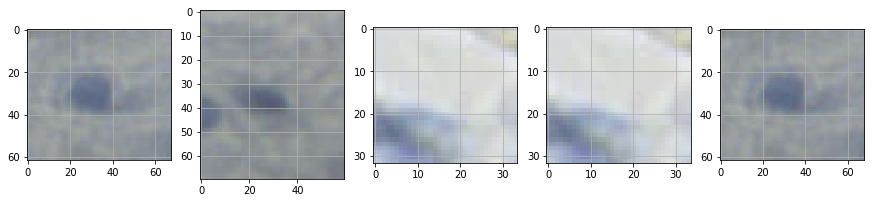

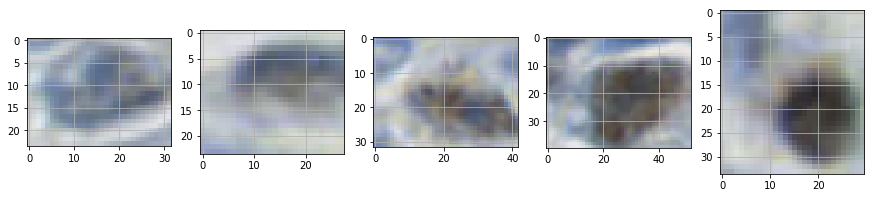

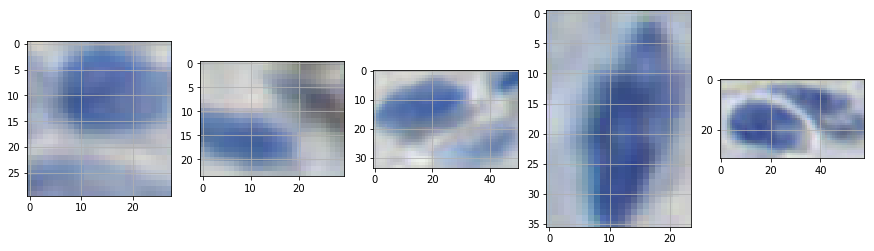

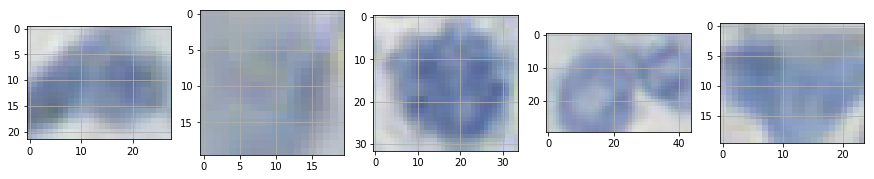

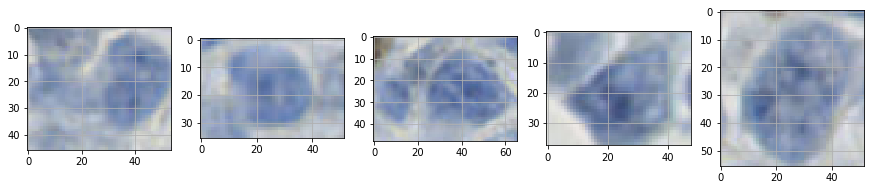

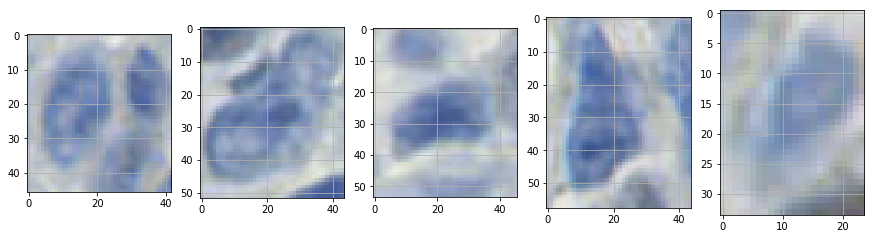

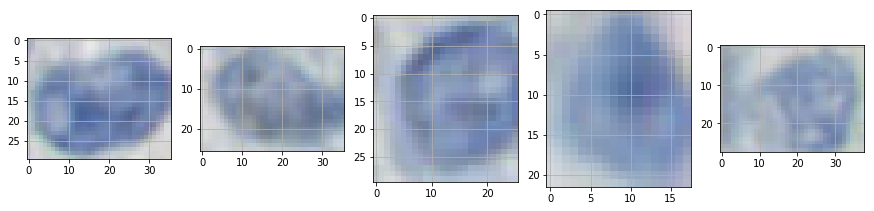

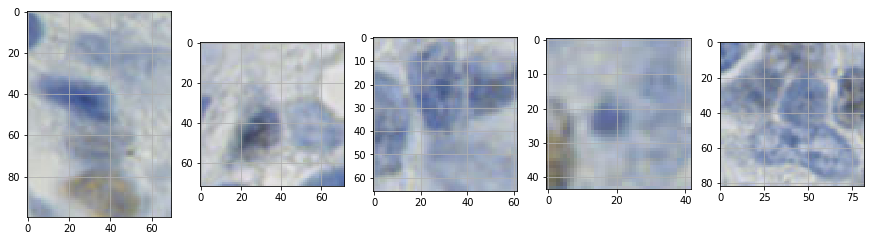

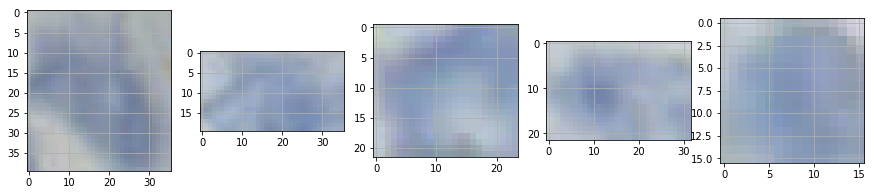

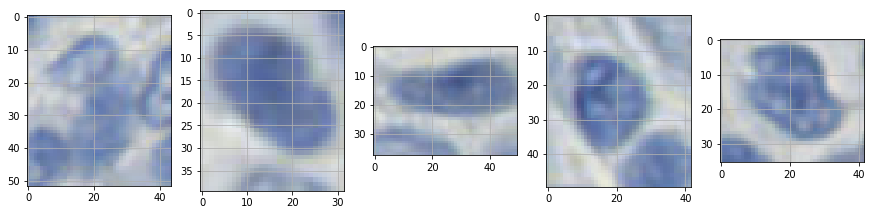

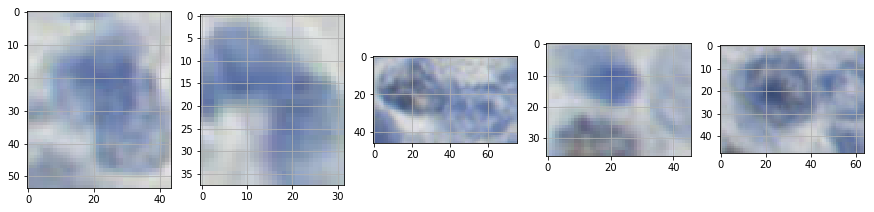

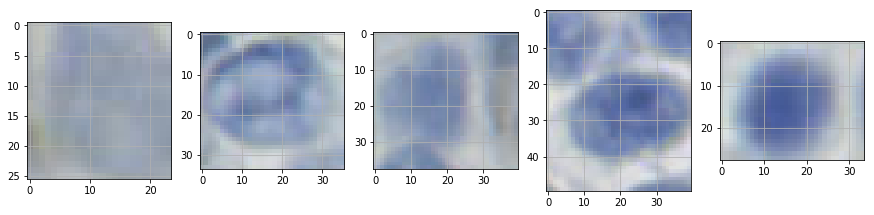

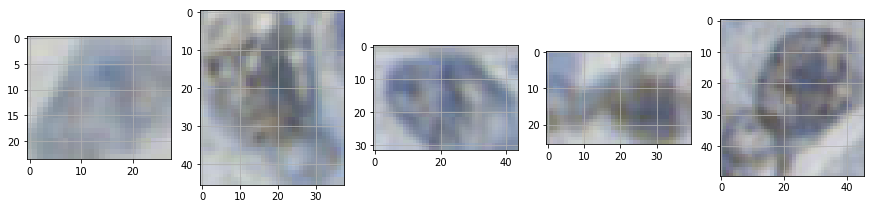

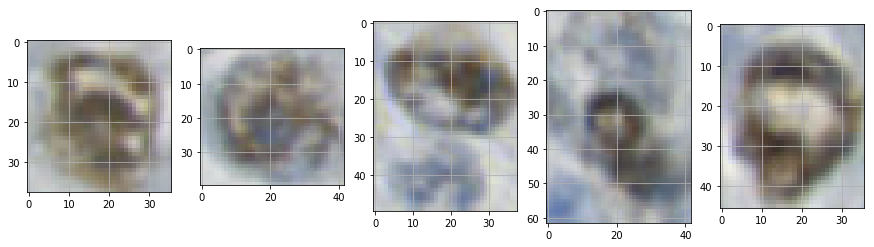

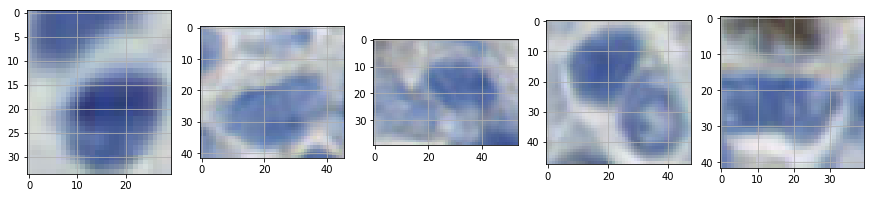

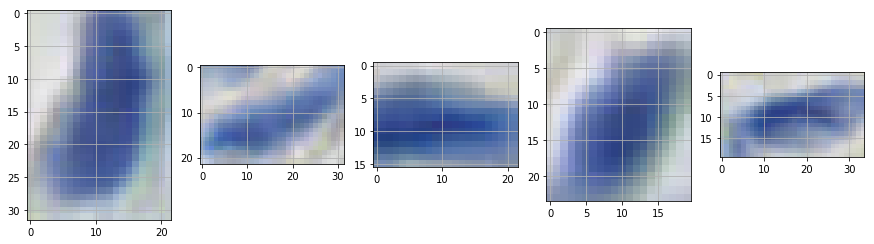

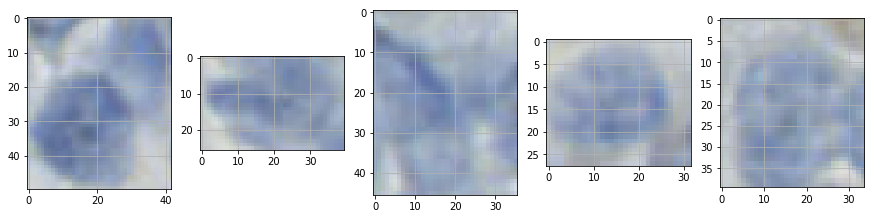

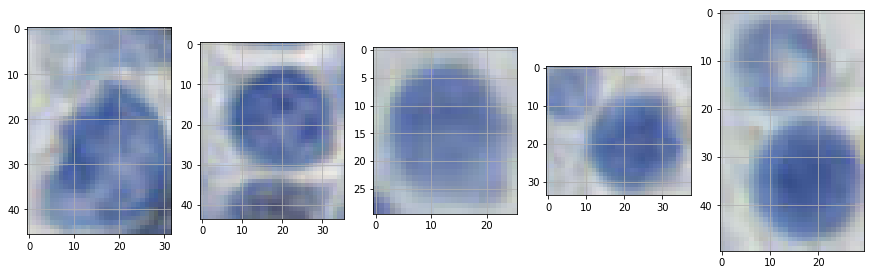

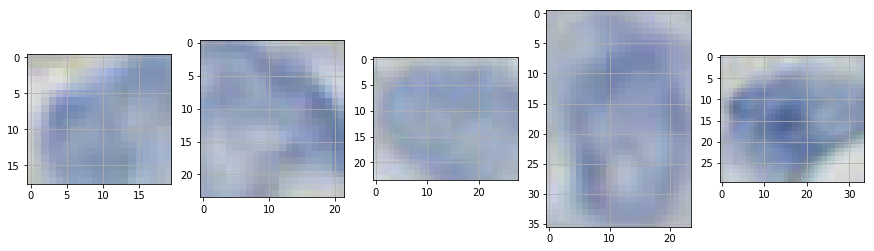

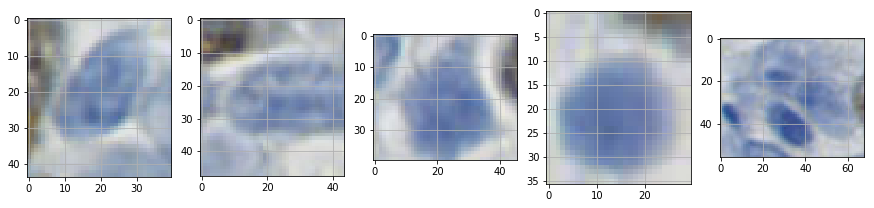

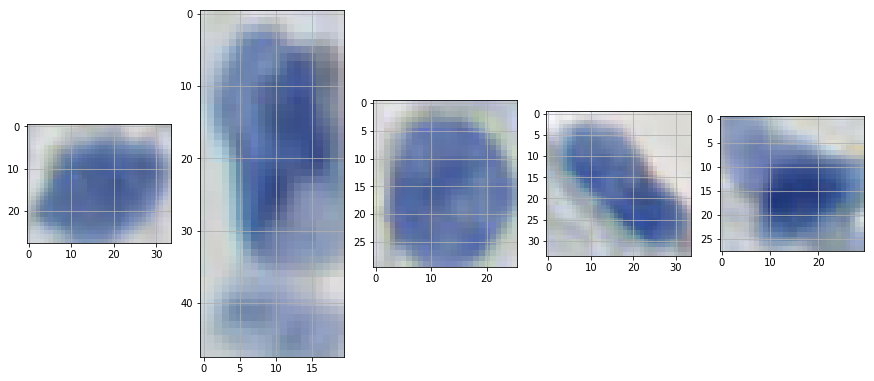

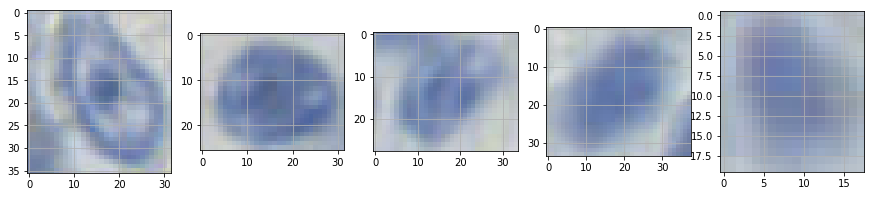

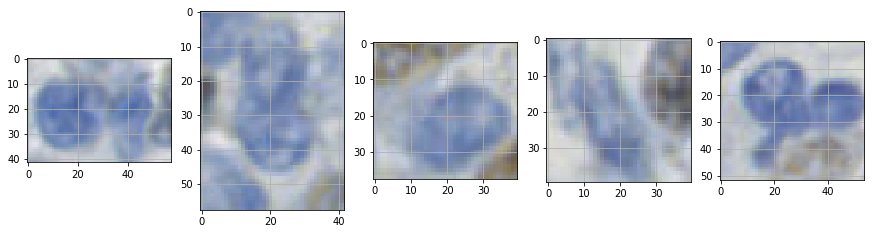

In [72]:
n_clusters = km_model.named_steps['cluster'].n_clusters
num_images = 5

ts = large_image.getTileSource(os.path.join(DATA_ROOT_DIR, sample_file))

for i in range(n_clusters):
    
    if not np.any(sample_clusters == i):
        continue

    cur_anot = np.random.choice(sample_anot[sample_clusters == i], num_images)
    
    plt.figure()
    
    for j in range(num_images):
        
        if 'points' in cur_anot[j]:
            
            plt.subplot(1, num_images, j+1)        
            p1 = np.min(cur_anot[j]['points'], axis=0)
            p2 = np.max(cur_anot[j]['points'], axis=0)
            sz = p2 - p1
            
            left = p1[0]
            right = p1[1]
            w = sz[0]
            h = sz[1]
            
        else:
        
            w = cur_anot[j]['width']
            h = cur_anot[j]['height']
            left = cur_anot[j]['center'][0] - 0.5 * w
            top = cur_anot[j]['center'][1] - 0.5 * h
        
        im_roi, _ = ts.getRegion(
            region=dict(left=left, top=top, width=w, height=h, units='base_pixels'),
            format=large_image.tilesource.TILE_FORMAT_NUMPY
        )

        plt.subplot(1, num_images, j+1)
        plt.imshow(im_roi)